In [1]:
import os, sys, csv, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# change settings so that pandas will display 100 rows of data
pd.set_option('display.max_rows', 100)

In [3]:
grid_name = 'CISO'

grid_data_folder = 'grid-emissions'
weather_data_folder = 'weather-station-result'

In [4]:
grid_emissions_file_2019 = os.path.join(grid_data_folder, grid_name + '-' + '2019' + '.csv')
grid_emissions_file_2020 = os.path.join(grid_data_folder, grid_name + '-' + '2020' + '.csv')
grid_emissions_file_2021 = os.path.join(grid_data_folder, grid_name + '-' + '2021' + '.csv')

SF_weather_file_2019 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2019' + '.csv')
SF_weather_file_2020 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2020' + '.csv')
SF_weather_file_2021 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2021' + '.csv')

LA_weather_file_2019 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2019' + '.csv')
LA_weather_file_2020 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2020' + '.csv')
LA_weather_file_2021 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2021' + '.csv')

In [5]:
df_SF_weather_2019 = pd.read_csv(SF_weather_file_2019, usecols=['date_time', 'dry_bulb'])
df_SF_weather_2020 = pd.read_csv(SF_weather_file_2020, usecols=['date_time', 'dry_bulb'])
df_SF_weather_2021 = pd.read_csv(SF_weather_file_2021, usecols=['date_time', 'dry_bulb'])

df_LA_weather_2019 = pd.read_csv(LA_weather_file_2019, usecols=['date_time', 'dry_bulb'])
df_LA_weather_2020 = pd.read_csv(LA_weather_file_2020, usecols=['date_time', 'dry_bulb'])
df_LA_weather_2021 = pd.read_csv(LA_weather_file_2021, usecols=['date_time', 'dry_bulb'])

df_grid_emissions_2019 = pd.read_csv(grid_emissions_file_2019, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])
df_grid_emissions_2020 = pd.read_csv(grid_emissions_file_2020, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])
df_grid_emissions_2021 = pd.read_csv(grid_emissions_file_2021, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])

In [6]:
# remove leap day data from df_grid_emissions_2020 (since weather file removed it)
df_grid_emissions_2020 = df_grid_emissions_2020[~df_grid_emissions_2020['datetime_local'].str.contains('02-29')]

In [7]:
df_grid_emissions_2020.shape

(8760, 2)

In [8]:
df_SF_weather_3yrs = pd.concat([df_SF_weather_2019, df_SF_weather_2020, df_SF_weather_2021]).rename(columns={'dry_bulb': 'SF_temp'})
df_LA_weather_3yrs = pd.concat([df_LA_weather_2019, df_LA_weather_2020, df_LA_weather_2021]).rename(columns={'dry_bulb': 'LA_temp'})

df_CA_weather_3yrs = pd.merge(df_SF_weather_3yrs, df_LA_weather_3yrs, on='date_time')

In [9]:
# find the rows with null values
df_CA_weather_3yrs[df_CA_weather_3yrs.isnull().any(axis=1)]

,date_time,SF_temp,LA_temp
22106,2021-07-11-02:00,NaN,18.992308
22107,2021-07-11-03:00,NaN,18.023077
22108,2021-07-11-04:00,NaN,18.176923
22109,2021-07-11-05:00,NaN,18.800000
22110,2021-07-11-06:00,NaN,20.430769
22111,2021-07-11-07:00,NaN,21.130769
22112,2021-07-11-08:00,NaN,22.446154
22113,2021-07-11-09:00,NaN,22.792308
22114,2021-07-11-10:00,NaN,23.300000
22115,2021-07-11-11:00,NaN,23.530769


In [10]:
df_CA_weather_3yrs.isnull().sum()

date_time     0
SF_temp      12
LA_temp       0
dtype: int64

In [11]:
# interpolate the null values
df_CA_weather_3yrs[['SF_temp', 'LA_temp']] = df_CA_weather_3yrs[['SF_temp', 'LA_temp']].interpolate()

In [12]:
# convert date_time column to datetime type
df_CA_weather_3yrs['date_time'] = pd.to_datetime(df_CA_weather_3yrs['date_time'])
df_CA_weather_3yrs.reset_index(drop=True)
df_CA_weather_3yrs

,date_time,SF_temp,LA_temp
0,2019-01-01 00:00:00,10.661538,10.757143
1,2019-01-01 01:00:00,10.538462,10.238462
2,2019-01-01 02:00:00,9.876923,9.723077
3,2019-01-01 03:00:00,9.223077,7.930769
4,2019-01-01 04:00:00,8.561538,7.446154
...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923
26276,2021-12-31 20:00:00,8.992308,12.015385
26277,2021-12-31 21:00:00,8.253846,11.976923
26278,2021-12-31 22:00:00,8.684615,12.092308


In [13]:
df_CA_weather_3yrs.dtypes

date_time    datetime64[ns]
SF_temp             float64
LA_temp             float64
dtype: object

In [14]:
# create columns for moving average of temperature for 3 hours, 6 hours
df_CA_weather_3yrs['SF_temp_3hr'] = df_CA_weather_3yrs['SF_temp'].rolling(3).mean()
df_CA_weather_3yrs['SF_temp_6hr'] = df_CA_weather_3yrs['SF_temp'].rolling(6).mean()
df_CA_weather_3yrs['LA_temp_3hr'] = df_CA_weather_3yrs['LA_temp'].rolling(3).mean()
df_CA_weather_3yrs['LA_temp_6hr'] = df_CA_weather_3yrs['LA_temp'].rolling(6).mean()

In [15]:
df_CA_weather_3yrs

,date_time,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr
0,2019-01-01 00:00:00,10.661538,10.757143,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,10.538462,10.238462,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,9.876923,9.723077,10.358974,NaN,10.239560,NaN
3,2019-01-01 03:00:00,9.223077,7.930769,9.879487,NaN,9.297436,NaN
4,2019-01-01 04:00:00,8.561538,7.446154,9.220513,NaN,8.366667,NaN
...,...,...,...,...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923,9.584615,10.612821,13.007692,13.500000
26276,2021-12-31 20:00:00,8.992308,12.015385,9.146154,10.179487,12.492308,13.170513
26277,2021-12-31 21:00:00,8.253846,11.976923,8.758974,9.558974,12.156410,12.834615
26278,2021-12-31 22:00:00,8.684615,12.092308,8.643590,9.114103,12.028205,12.517949


In [16]:
# backfill the null values in the moving average columns
df_CA_weather_3yrs[['SF_temp_3hr', 'SF_temp_6hr', 'LA_temp_3hr', 'LA_temp_6hr']] = df_CA_weather_3yrs[['SF_temp_3hr', 'SF_temp_6hr', 'LA_temp_3hr', 'LA_temp_6hr']].fillna(method='bfill')

In [17]:
df_CA_weather_3yrs

,date_time,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr
0,2019-01-01 00:00:00,10.661538,10.757143,10.358974,9.539744,10.239560,8.968498
1,2019-01-01 01:00:00,10.538462,10.238462,10.358974,9.539744,10.239560,8.968498
2,2019-01-01 02:00:00,9.876923,9.723077,10.358974,9.539744,10.239560,8.968498
3,2019-01-01 03:00:00,9.223077,7.930769,9.879487,9.539744,9.297436,8.968498
4,2019-01-01 04:00:00,8.561538,7.446154,9.220513,9.539744,8.366667,8.968498
...,...,...,...,...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923,9.584615,10.612821,13.007692,13.500000
26276,2021-12-31 20:00:00,8.992308,12.015385,9.146154,10.179487,12.492308,13.170513
26277,2021-12-31 21:00:00,8.253846,11.976923,8.758974,9.558974,12.156410,12.834615
26278,2021-12-31 22:00:00,8.684615,12.092308,8.643590,9.114103,12.028205,12.517949


In [18]:
df_grid_emissions_3yrs = pd.concat([df_grid_emissions_2019, df_grid_emissions_2020, df_grid_emissions_2021]).rename(columns={'consumed_co2e_rate_kg_per_mwh_for_electricity': 'grid_emissions'})

In [19]:
# re-index df_grid_emissions_3yrs
df_grid_emissions_3yrs = df_grid_emissions_3yrs.reset_index(drop=True)
df_grid_emissions_3yrs

,datetime_local,grid_emissions
0,2019-01-01 00:00:00-08:00,308.79
1,2019-01-01 01:00:00-08:00,309.58
2,2019-01-01 02:00:00-08:00,314.50
3,2019-01-01 03:00:00-08:00,316.74
4,2019-01-01 04:00:00-08:00,316.34
...,...,...
26275,2021-12-31 19:00:00-08:00,273.29
26276,2021-12-31 20:00:00-08:00,277.30
26277,2021-12-31 21:00:00-08:00,277.92
26278,2021-12-31 22:00:00-08:00,266.93


In [20]:
df_combined_3yrs = pd.merge(df_CA_weather_3yrs, df_grid_emissions_3yrs, left_index=True, right_index=True).drop(columns=['datetime_local'])
df_combined_3yrs

,date_time,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr,grid_emissions
0,2019-01-01 00:00:00,10.661538,10.757143,10.358974,9.539744,10.239560,8.968498,308.79
1,2019-01-01 01:00:00,10.538462,10.238462,10.358974,9.539744,10.239560,8.968498,309.58
2,2019-01-01 02:00:00,9.876923,9.723077,10.358974,9.539744,10.239560,8.968498,314.50
3,2019-01-01 03:00:00,9.223077,7.930769,9.879487,9.539744,9.297436,8.968498,316.74
4,2019-01-01 04:00:00,8.561538,7.446154,9.220513,9.539744,8.366667,8.968498,316.34
...,...,...,...,...,...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923,9.584615,10.612821,13.007692,13.500000,273.29
26276,2021-12-31 20:00:00,8.992308,12.015385,9.146154,10.179487,12.492308,13.170513,277.30
26277,2021-12-31 21:00:00,8.253846,11.976923,8.758974,9.558974,12.156410,12.834615,277.92
26278,2021-12-31 22:00:00,8.684615,12.092308,8.643590,9.114103,12.028205,12.517949,266.93


In [21]:
#create columns for month, day of week, and hour of day
df_combined_3yrs['month'] = df_combined_3yrs['date_time'].dt.month
df_combined_3yrs['day_of_week'] = df_combined_3yrs['date_time'].dt.dayofweek
df_combined_3yrs['hour_of_day'] = df_combined_3yrs['date_time'].dt.hour

# create a column for weekend vs weekday
df_combined_3yrs['weekend'] = df_combined_3yrs['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# add a column for day of year
# df_combined_3yrs['day_of_year'] = df_combined_3yrs['date_time'].dt.dayofyear

In [22]:
df_combined_3yrs.head()

,date_time,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr,grid_emissions,month,day_of_week,hour_of_day,weekend
0,2019-01-01 00:00:00,10.661538,10.757143,10.358974,9.539744,10.239560,8.968498,308.79,1,1,0,0
1,2019-01-01 01:00:00,10.538462,10.238462,10.358974,9.539744,10.239560,8.968498,309.58,1,1,1,0
2,2019-01-01 02:00:00,9.876923,9.723077,10.358974,9.539744,10.239560,8.968498,314.50,1,1,2,0
3,2019-01-01 03:00:00,9.223077,7.930769,9.879487,9.539744,9.297436,8.968498,316.74,1,1,3,0
4,2019-01-01 04:00:00,8.561538,7.446154,9.220513,9.539744,8.366667,8.968498,316.34,1,1,4,0


In [23]:
df_combined_3yrs_withdummies = pd.get_dummies(df_combined_3yrs, columns=['month', 'day_of_week', 'hour_of_day'])

In [24]:
df_combined_3yrs_withdummies.head()

,date_time,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr,grid_emissions,weekend,month_1,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,2019-01-01 00:00:00,10.661538,10.757143,10.358974,9.539744,10.239560,8.968498,308.79,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 01:00:00,10.538462,10.238462,10.358974,9.539744,10.239560,8.968498,309.58,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 02:00:00,9.876923,9.723077,10.358974,9.539744,10.239560,8.968498,314.50,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 03:00:00,9.223077,7.930769,9.879487,9.539744,9.297436,8.968498,316.74,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 04:00:00,8.561538,7.446154,9.220513,9.539744,8.366667,8.968498,316.34,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# create a new dataframe for data with year 2019 or 2020
df_combined_2019_2020 = df_combined_3yrs[df_combined_3yrs['date_time'].dt.year.isin([2019, 2020])].reset_index(drop=True)
df_combined_2019_2020_w_dummies = df_combined_3yrs_withdummies[df_combined_3yrs_withdummies['date_time'].dt.year.isin([2019, 2020])].reset_index(drop=True)

# create a new dataframe for data with year 2021
df_combined_2021 = df_combined_3yrs[df_combined_3yrs['date_time'].dt.year.isin([2021])].reset_index(drop=True)
df_combined_2021_w_dummies = df_combined_3yrs_withdummies[df_combined_3yrs_withdummies['date_time'].dt.year.isin([2021])].reset_index(drop=True)

In [26]:
df_combined_2019_2020.shape, df_combined_2021.shape

((17520, 12), (8760, 12))

In [27]:
df_combined_2019_2020

,date_time,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr,grid_emissions,month,day_of_week,hour_of_day,weekend
0,2019-01-01 00:00:00,10.661538,10.757143,10.358974,9.539744,10.239560,8.968498,308.79,1,1,0,0
1,2019-01-01 01:00:00,10.538462,10.238462,10.358974,9.539744,10.239560,8.968498,309.58,1,1,1,0
2,2019-01-01 02:00:00,9.876923,9.723077,10.358974,9.539744,10.239560,8.968498,314.50,1,1,2,0
3,2019-01-01 03:00:00,9.223077,7.930769,9.879487,9.539744,9.297436,8.968498,316.74,1,1,3,0
4,2019-01-01 04:00:00,8.561538,7.446154,9.220513,9.539744,8.366667,8.968498,316.34,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2020-12-31 19:00:00,11.546154,15.769231,11.956410,13.017949,15.923077,17.037179,292.99,12,3,19,0
17516,2020-12-31 20:00:00,10.846154,15.000000,11.464103,12.371795,15.589744,16.365385,293.91,12,3,20,0
17517,2020-12-31 21:00:00,9.300000,14.569231,10.564103,11.589744,15.112821,15.744872,294.06,12,3,21,0
17518,2020-12-31 22:00:00,8.761538,14.069231,9.635897,10.796154,14.546154,15.234615,294.99,12,3,22,0


In [28]:
# X_train = df_combined_2019_2020.drop(columns=['date_time', 'grid_emissions', 'day_of_week'])
# y_train = df_combined_2019_2020['grid_emissions']

# X_test = df_combined_2021.drop(columns=['date_time', 'grid_emissions', 'day_of_week'])
# y_test = df_combined_2021['grid_emissions']

X_train = df_combined_2019_2020_w_dummies.drop(columns=['date_time', 'grid_emissions'])
y_train = df_combined_2019_2020_w_dummies['grid_emissions']

X_test = df_combined_2021_w_dummies.drop(columns=['date_time', 'grid_emissions'])
y_test = df_combined_2021_w_dummies['grid_emissions']

In [29]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [30]:
X_train.head()

,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr,weekend,month_1,month_2,month_3,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,10.661538,10.757143,10.358974,9.539744,10.239560,8.968498,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.538462,10.238462,10.358974,9.539744,10.239560,8.968498,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.876923,9.723077,10.358974,9.539744,10.239560,8.968498,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.223077,7.930769,9.879487,9.539744,9.297436,8.968498,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.561538,7.446154,9.220513,9.539744,8.366667,8.968498,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# use standard scalar on df_CA_weather_grid to scale columns 'SF_dry_bulb', 'LA_dry_bulb'
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['SF_temp', 'LA_temp', 'SF_temp_3hr', 'SF_temp_6hr', 'LA_temp_3hr', 'LA_temp_6hr']] = scaler.fit_transform(X_train_scaled[['SF_temp', 'LA_temp', 'SF_temp_3hr', 'SF_temp_6hr', 'LA_temp_3hr', 'LA_temp_6hr']])
X_test_scaled[['SF_temp', 'LA_temp', 'SF_temp_3hr', 'SF_temp_6hr', 'LA_temp_3hr', 'LA_temp_6hr']] = scaler.transform(X_test_scaled[['SF_temp', 'LA_temp', 'SF_temp_3hr', 'SF_temp_6hr', 'LA_temp_3hr', 'LA_temp_6hr']])

In [32]:
# get scaler mean and std
scaler_mean = scaler.mean_
scaler_std = scaler.scale_
scaler_mean, scaler_std

(array([14.79381011, 17.58368283, 14.79387904, 14.79374484, 17.58351102,
        17.58286919]),
 array([4.3586109 , 4.08224107, 4.29275407, 4.15070855, 4.02548704,
        3.90087742]))

In [33]:
X_train_scaled.head()

,SF_temp,LA_temp,SF_temp_3hr,SF_temp_6hr,LA_temp_3hr,LA_temp_6hr,weekend,month_1,month_2,month_3,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,-0.948071,-1.672253,-1.033114,-1.265808,-1.824363,-2.208316,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.976308,-1.799311,-1.033114,-1.265808,-1.824363,-2.208316,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.128086,-1.925561,-1.033114,-1.265808,-1.824363,-2.208316,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.278098,-2.364611,-1.144811,-1.265808,-2.058403,-2.208316,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.429876,-2.483324,-1.298319,-1.265808,-2.289622,-2.208316,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# predict
y_pred_train_linreg = linreg.predict(X_train_scaled)
y_pred_test_linreg = linreg.predict(X_test_scaled)

# MSE and RMSE
linreg_mse_train = mean_squared_error(y_train, y_pred_train_linreg)
linreg_mse_test = mean_squared_error(y_test, y_pred_test_linreg)
linreg_rmse_train = np.sqrt(linreg_mse_train)
linreg_rmse_test = np.sqrt(linreg_mse_test)

# r2 score
linreg_r2_train = r2_score(y_train, y_pred_train_linreg)
linreg_r2_test = r2_score(y_test, y_pred_test_linreg)

In [35]:
y_pred_train_linreg

array([289.07080078, 289.82519531, 293.10449219, ..., 327.36474609,
       327.87744141, 329.19824219])

In [36]:
# Make a table of results for train and test errors
d = {'train': [linreg_mse_train, linreg_rmse_train, linreg_r2_train], 'test': [linreg_mse_test, linreg_rmse_test, linreg_r2_test]}
df_linreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Simple Multi-Linear Regression:')
df_linreg_results

Simple Multi-Linear Regression:


,train,test
MSE,899.716616,1429.473823
RMSE,29.995277,37.808383
R2,0.798487,0.598889


In [37]:
# polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

polyreg = LinearRegression(fit_intercept=False)
polyreg.fit(X_train_poly, y_train)

# predict
y_pred_poly_train = polyreg.predict(X_train_poly)
y_pred_poly_test = polyreg.predict(X_test_poly)

# MSE and RMSE
polyreg_mse_train = mean_squared_error(y_train, y_pred_poly_train)
polyreg_rmse_train = np.sqrt(polyreg_mse_train)
polyreg_mse_test = mean_squared_error(y_test, y_pred_poly_test)
polyreg_rmse_test = np.sqrt(polyreg_mse_test)

# r2 score
polyreg_r2_train = r2_score(y_train, y_pred_poly_train)
polyreg_r2_test = r2_score(y_test, y_pred_poly_test)

In [38]:
# Make a table of results for train and test errors
d = {'train': [polyreg_mse_train, polyreg_rmse_train, polyreg_r2_train], 'test': [polyreg_mse_test, polyreg_rmse_test, polyreg_r2_test]}
df_polyreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Polynomial Regression (degree=2):')
df_polyreg_results

Polynomial Regression (degree=2):


,train,test
MSE,625.321292,1408.630388
RMSE,25.006425,37.531725
R2,0.859944,0.604738


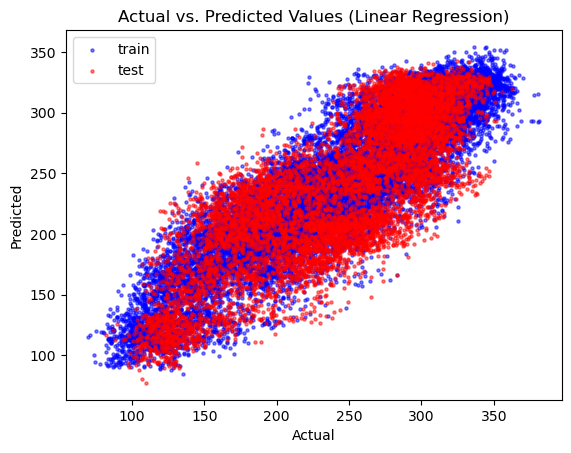

In [39]:
# plot actual vs predicted values for train and test sets
plt.scatter(y_train, y_pred_train_linreg, color='blue', label='train', s=5, alpha=.5)
plt.scatter(y_test, y_pred_test_linreg, color='red', label='test', s=5, alpha = .5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.legend()


In [40]:
# # polynomial regression
# poly = PolynomialFeatures(degree=3, include_bias=True)
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly = poly.fit_transform(X_test_scaled)

# polyreg = LinearRegression(fit_intercept=False)
# polyreg.fit(X_train_poly, y_train)

# # predict
# y_pred_poly_train = polyreg.predict(X_train_poly)
# y_pred_poly_test = polyreg.predict(X_test_poly)

# # MSE and RMSE
# polyreg_mse_train = mean_squared_error(y_train, y_pred_poly_train)
# polyreg_rmse_train = np.sqrt(polyreg_mse_train)
# polyreg_mse_test = mean_squared_error(y_test, y_pred_poly_test)
# polyreg_rmse_test = np.sqrt(polyreg_mse_test)

# # r2 score
# polyreg_r2_train = r2_score(y_train, y_pred_poly_train)
# polyreg_r2_test = r2_score(y_test, y_pred_poly_test)

In [41]:
# # Make a table of results for train and test errors
# d = {'train': [polyreg_mse_train, polyreg_rmse_train, polyreg_r2_train], 'test': [polyreg_mse_test, polyreg_rmse_test, polyreg_r2_test]}
# df_polyreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
# print('Polynomial Regression (degree=3):')
# df_polyreg_results

In [42]:
## Polynomial Regression without scaled data

# polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

polyreg = LinearRegression(fit_intercept=False)
polyreg.fit(X_train_poly, y_train)

# predict
y_pred_poly_train = polyreg.predict(X_train_poly)
y_pred_poly_test = polyreg.predict(X_test_poly)

# MSE and RMSE
polyreg_mse_train = mean_squared_error(y_train, y_pred_poly_train)
polyreg_rmse_train = np.sqrt(polyreg_mse_train)
polyreg_mse_test = mean_squared_error(y_test, y_pred_poly_test)
polyreg_rmse_test = np.sqrt(polyreg_mse_test)

# r2 score
polyreg_r2_train = r2_score(y_train, y_pred_poly_train)
polyreg_r2_test = r2_score(y_test, y_pred_poly_test)

In [43]:
# Make a table of results for train and test errors
d = {'train': [polyreg_mse_train, polyreg_rmse_train, polyreg_r2_train], 'test': [polyreg_mse_test, polyreg_rmse_test, polyreg_r2_test]}
df_polyreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Polynomial Regression (degree=2):')
df_polyreg_results

Polynomial Regression (degree=2):


,train,test
MSE,622.704609,1410.493317
RMSE,24.954050,37.556535
R2,0.860530,0.604215


In [44]:
# Ridge Regression
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)

# predict
y_pred_train_ridge = ridge.predict(X_train)
y_pred_test_ridge = ridge.predict(X_test)

# MSE and RMSE
ridge_mse_train = mean_squared_error(y_train, y_pred_train_ridge)
ridge_rmse_train = np.sqrt(ridge_mse_train)
ridge_mse_test = mean_squared_error(y_test, y_pred_test_ridge)
ridge_rmse_test = np.sqrt(ridge_mse_test)

# r2 score
ridge_r2_train = r2_score(y_train, y_pred_train_ridge)
ridge_r2_test = r2_score(y_test, y_pred_test_ridge)


c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [45]:
# Make a table of results for train and test errors
d = {'train': [ridge_mse_train, ridge_rmse_train, ridge_r2_train], 'test': [ridge_mse_test, ridge_rmse_test, ridge_r2_test]}
df_ridge_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Ridge Regression:')
df_ridge_results

Ridge Regression:


,train,test
MSE,942.218181,1336.498068
RMSE,30.695573,36.558146
R2,0.788967,0.624978


In [46]:
# Lasso Regression
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train_poly, y_train)

# predict
y_pred_train_lasso = lasso.predict(X_train_poly)
y_pred_test_lasso = lasso.predict(X_test_poly)

# MSE and RMSE
lasso_mse_train = mean_squared_error(y_train, y_pred_train_lasso)
lasso_rmse_train = np.sqrt(lasso_mse_train)
lasso_mse_test = mean_squared_error(y_test, y_pred_test_lasso)
lasso_rmse_test = np.sqrt(lasso_mse_test)

# r2 score
lasso_r2_train = r2_score(y_train, y_pred_train_lasso)
lasso_r2_test = r2_score(y_test, y_pred_test_lasso)


c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [47]:
# Make a table of results for train and test errors
d = {'train': [lasso_mse_train, lasso_rmse_train, lasso_r2_train], 'test': [lasso_mse_test, lasso_rmse_test, lasso_r2_test]}
df_lasso_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Lasso Regression:')
df_lasso_results

Lasso Regression:


,train,test
MSE,3346.965162,2876.378066
RMSE,57.852962,53.631875
R2,0.250366,0.192888


In [48]:
# use ridge regression on the polynomial features data
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train_poly, y_train)

# predict
y_pred_train_ridge_poly = ridge.predict(X_train_poly)
y_pred_test_ridge_poly = ridge.predict(X_test_poly)

# MSE and RMSE
ridge_mse_train_poly = mean_squared_error(y_train, y_pred_train_ridge_poly)
ridge_rmse_train_poly = np.sqrt(ridge_mse_train_poly)
ridge_mse_test_poly = mean_squared_error(y_test, y_pred_test_ridge_poly)
ridge_rmse_test_poly = np.sqrt(ridge_mse_test_poly)

# r2 score
ridge_r2_train_poly = r2_score(y_train, y_pred_train_ridge_poly)
ridge_r2_test_poly = r2_score(y_test, y_pred_test_ridge_poly)

c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [49]:
# Make a table of results for train and test errors
d = {'train': [ridge_mse_train_poly, ridge_rmse_train_poly, ridge_r2_train_poly], 'test': [ridge_mse_test_poly, ridge_rmse_test_poly, ridge_r2_test_poly]}
df_ridge_poly_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Ridge Regression (polynomial features):')
df_ridge_poly_results

Ridge Regression (polynomial features):


,train,test
MSE,716.642099,1262.469674
RMSE,26.770172,35.531249
R2,0.839491,0.645751


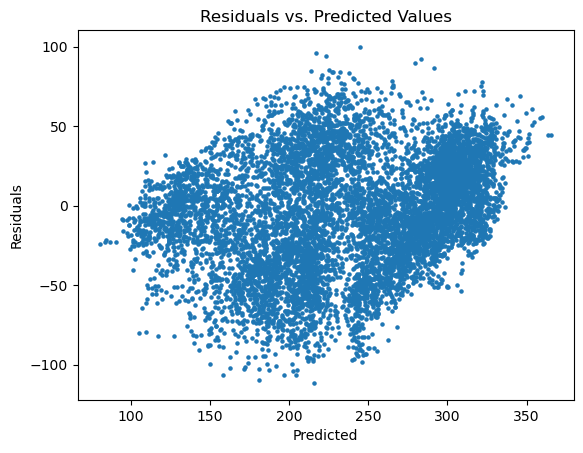

In [50]:
# create a plot showing the residuals of the ridge regression model
residuals = y_pred_test_ridge_poly - y_test
plt.scatter(y_pred_test_ridge_poly, residuals, s=5)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

In [51]:
np.mean(residuals)

-4.995702420068649

In [52]:
# import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

In [53]:
# try a KNN regression model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# predict
y_pred_train_knn = knn.predict(X_train)
y_pred_test_knn = knn.predict(X_test)

# MSE and RMSE
knn_mse_train = mean_squared_error(y_train, y_pred_train_knn)
knn_rmse_train = np.sqrt(knn_mse_train)
knn_mse_test = mean_squared_error(y_test, y_pred_test_knn)
knn_rmse_test = np.sqrt(knn_mse_test)

# r2 score
knn_r2_train = r2_score(y_train, y_pred_train_knn)
knn_r2_test = r2_score(y_test, y_pred_test_knn)

# Make a table of results for train and test errors
d = {'train': [knn_mse_train, knn_rmse_train, knn_r2_train], 'test': [knn_mse_test, knn_rmse_test, knn_r2_test]}
df_knn_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('KNN Regression:')
df_knn_results


KNN Regression:


,train,test
MSE,727.352022,1971.178254
RMSE,26.969465,44.397953
R2,0.837092,0.446887


In [54]:
# try a decision KNN regression model with polynomial features
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_poly, y_train)

# predict
y_pred_train_knn_poly = knn.predict(X_train_poly)
y_pred_test_knn_poly = knn.predict(X_test_poly)

# MSE and RMSE
knn_mse_train_poly = mean_squared_error(y_train, y_pred_train_knn_poly)
knn_rmse_train_poly = np.sqrt(knn_mse_train_poly)
knn_mse_test_poly = mean_squared_error(y_test, y_pred_test_knn_poly)
knn_rmse_test_poly = np.sqrt(knn_mse_test_poly)

# r2 score
knn_r2_train_poly = r2_score(y_train, y_pred_train_knn_poly)
knn_r2_test_poly = r2_score(y_test, y_pred_test_knn_poly)

# Make a table of results for train and test errors
d = {'train': [knn_mse_train_poly, knn_rmse_train_poly, knn_r2_train_poly], 'test': [knn_mse_test_poly, knn_rmse_test_poly, knn_r2_test_poly]}
df_knn_poly_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('KNN Regression (polynomial features):')
df_knn_poly_results

KNN Regression (polynomial features):


,train,test
MSE,872.261773,2009.782012
RMSE,29.534078,44.830592
R2,0.804636,0.436055


In [55]:
# try a decision tree regression model
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)

# predict
y_pred_train_tree = tree.predict(X_train)
y_pred_test_tree = tree.predict(X_test)

# MSE and RMSE
tree_mse_train = mean_squared_error(y_train, y_pred_train_tree)
tree_rmse_train = np.sqrt(tree_mse_train)
tree_mse_test = mean_squared_error(y_test, y_pred_test_tree)
tree_rmse_test = np.sqrt(tree_mse_test)

# r2 score
tree_r2_train = r2_score(y_train, y_pred_train_tree)
tree_r2_test = r2_score(y_test, y_pred_test_tree)

# Make a table of results for train and test errors
d = {'train': [tree_mse_train, tree_rmse_train, tree_r2_train], 'test': [tree_mse_test, tree_rmse_test, tree_r2_test]}
df_tree_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Decision Tree Regression:')
df_tree_results

Decision Tree Regression:


,train,test
MSE,2259.476391,3133.666112
RMSE,47.533950,55.979158
R2,0.493935,0.120693


In [56]:
# try a random forest regression model
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

# predict
y_pred_train_forest = forest.predict(X_train)
y_pred_test_forest = forest.predict(X_test)

# MSE and RMSE
forest_mse_train = mean_squared_error(y_train, y_pred_train_forest)
forest_rmse_train = np.sqrt(forest_mse_train)
forest_mse_test = mean_squared_error(y_test, y_pred_test_forest)
forest_rmse_test = np.sqrt(forest_mse_test)

# r2 score
forest_r2_train = r2_score(y_train, y_pred_train_forest)
forest_r2_test = r2_score(y_test, y_pred_test_forest)

# Make a table of results for train and test errors
d = {'train': [forest_mse_train, forest_rmse_train, forest_r2_train], 'test': [forest_mse_test, forest_rmse_test, forest_r2_test]}
df_forest_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Random Forest Regression:')
df_forest_results

Random Forest Regression:


,train,test
MSE,2107.250508,2890.149314
RMSE,45.904798,53.760109
R2,0.528030,0.189023


In [57]:
# try SVM regression
from sklearn.svm import SVR

svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

# predict
y_pred_train_svr = svr.predict(X_train)
y_pred_test_svr = svr.predict(X_test)

# MSE and RMSE
svr_mse_train = mean_squared_error(y_train, y_pred_train_svr)
svr_rmse_train = np.sqrt(svr_mse_train)
svr_mse_test = mean_squared_error(y_test, y_pred_test_svr)
svr_rmse_test = np.sqrt(svr_mse_test)

# r2 score
svr_r2_train = r2_score(y_train, y_pred_train_svr)
svr_r2_test = r2_score(y_test, y_pred_test_svr)

# Make a table of results for train and test errors
d = {'train': [svr_mse_train, svr_rmse_train, svr_r2_train], 'test': [svr_mse_test, svr_rmse_test, svr_r2_test]}
df_svr_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('SVM Regression: (linear kernel)')
df_svr_results

SVM Regression: (linear kernel)


,train,test
MSE,912.305562,1472.016399
RMSE,30.204396,38.366866
R2,0.795667,0.586952


In [58]:
# try SVM regressions with different kernels
# polynomial kernel, degree 2
svr = SVR(kernel='poly', degree=2)
svr.fit(X_train, y_train)

# predict
y_pred_train_svr = svr.predict(X_train)
y_pred_test_svr = svr.predict(X_test)

# MSE and RMSE
svr_mse_train = mean_squared_error(y_train, y_pred_train_svr)
svr_rmse_train = np.sqrt(svr_mse_train)
svr_mse_test = mean_squared_error(y_test, y_pred_test_svr)
svr_rmse_test = np.sqrt(svr_mse_test)

# r2 score
svr_r2_train = r2_score(y_train, y_pred_train_svr)
svr_r2_test = r2_score(y_test, y_pred_test_svr)

# Make a table of results for train and test errors
d = {'train': [svr_mse_train, svr_rmse_train, svr_r2_train], 'test': [svr_mse_test, svr_rmse_test, svr_r2_test]}
df_svr_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('SVM Regression: (polynomial kernel, degree=2)')
df_svr_results

SVM Regression: (polynomial kernel, degree=2)


,train,test
MSE,3596.891847,2541.087995
RMSE,59.974093,50.409205
R2,0.194388,0.286970


In [59]:
# try SVM regressions with different kernels
# polynomial kernel, degree 3
svr = SVR(kernel='poly', degree=3)
svr.fit(X_train, y_train)

# predict
y_pred_train_svr = svr.predict(X_train)
y_pred_test_svr = svr.predict(X_test)

# MSE and RMSE
svr_mse_train = mean_squared_error(y_train, y_pred_train_svr)
svr_rmse_train = np.sqrt(svr_mse_train)
svr_mse_test = mean_squared_error(y_test, y_pred_test_svr)
svr_rmse_test = np.sqrt(svr_mse_test)

# r2 score
svr_r2_train = r2_score(y_train, y_pred_train_svr)
svr_r2_test = r2_score(y_test, y_pred_test_svr)

# Make a table of results for train and test errors
d = {'train': [svr_mse_train, svr_rmse_train, svr_r2_train], 'test': [svr_mse_test, svr_rmse_test, svr_r2_test]}
df_svr_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('SVM Regression: (polynomial kernel, degree=3)')
df_svr_results

SVM Regression: (polynomial kernel, degree=3)


,train,test
MSE,3515.649293,2488.985197
RMSE,59.292911,49.889730
R2,0.212585,0.301590


In [60]:
# try SVM regressions with different kernels
# rbf kernel
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# predict
y_pred_train_svr = svr.predict(X_train)
y_pred_test_svr = svr.predict(X_test)

# MSE and RMSE
svr_mse_train = mean_squared_error(y_train, y_pred_train_svr)
svr_rmse_train = np.sqrt(svr_mse_train)
svr_mse_test = mean_squared_error(y_test, y_pred_test_svr)
svr_rmse_test = np.sqrt(svr_mse_test)

# r2 score
svr_r2_train = r2_score(y_train, y_pred_train_svr)
svr_r2_test = r2_score(y_test, y_pred_test_svr)

# Make a table of results for train and test errors
d = {'train': [svr_mse_train, svr_rmse_train, svr_r2_train], 'test': [svr_mse_test, svr_rmse_test, svr_r2_test]}
df_svr_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('SVM Regression: (rbf kernel)')
df_svr_results

SVM Regression: (rbf kernel)


,train,test
MSE,3284.714537,2542.829955
RMSE,57.312429,50.426481
R2,0.264308,0.286481


In [61]:
# try XGBoost
from xgboost import XGBRegressor

In [62]:
# try XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# predict
y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)

# MSE and RMSE
xgb_mse_train = mean_squared_error(y_train, y_pred_train_xgb)
xgb_rmse_train = np.sqrt(xgb_mse_train)
xgb_mse_test = mean_squared_error(y_test, y_pred_test_xgb)
xgb_rmse_test = np.sqrt(xgb_mse_test)

# r2 score
xgb_r2_train = r2_score(y_train, y_pred_train_xgb)
xgb_r2_test = r2_score(y_test, y_pred_test_xgb)

# Make a table of results for train and test errors
d = {'train': [xgb_mse_train, xgb_rmse_train, xgb_r2_train], 'test': [xgb_mse_test, xgb_rmse_test, xgb_r2_test]}
df_xgb_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('XGBoost Regression:')
df_xgb_results

XGBoost Regression:


,train,test
MSE,325.580857,1604.999692
RMSE,18.043859,40.062447
R2,0.927078,0.549637


In [63]:
# try XGBoost with polynomial features

xgb = XGBRegressor()
xgb.fit(X_train_poly, y_train)

# predict
y_pred_train_xgb = xgb.predict(X_train_poly)
y_pred_test_xgb = xgb.predict(X_test_poly)

# MSE and RMSE
xgb_mse_train = mean_squared_error(y_train, y_pred_train_xgb)
xgb_rmse_train = np.sqrt(xgb_mse_train)
xgb_mse_test = mean_squared_error(y_test, y_pred_test_xgb)
xgb_rmse_test = np.sqrt(xgb_mse_test)

# r2 score
xgb_r2_train = r2_score(y_train, y_pred_train_xgb)
xgb_r2_test = r2_score(y_test, y_pred_test_xgb)

# Make a table of results for train and test errors
d = {'train': [xgb_mse_train, xgb_rmse_train, xgb_r2_train], 'test': [xgb_mse_test, xgb_rmse_test, xgb_r2_test]}
df_xgb_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('XGBoost Regression: (with polynomial features)')
df_xgb_results


XGBoost Regression: (with polynomial features)


,train,test
MSE,327.392761,1586.544067
RMSE,18.093998,39.831446
R2,0.926672,0.554815
